Processing attack: DDoS-ALL
Iteration 1 out of 100


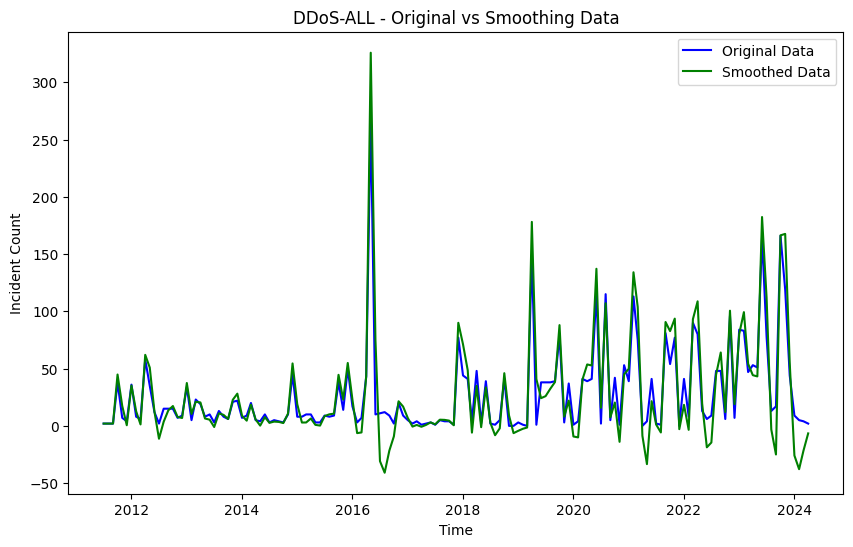

Iteration 2 out of 100


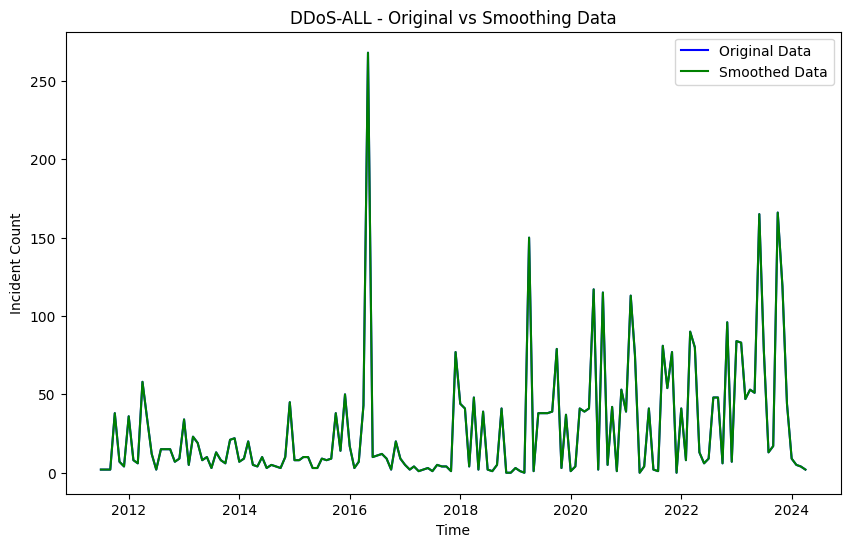

Iteration 3 out of 100


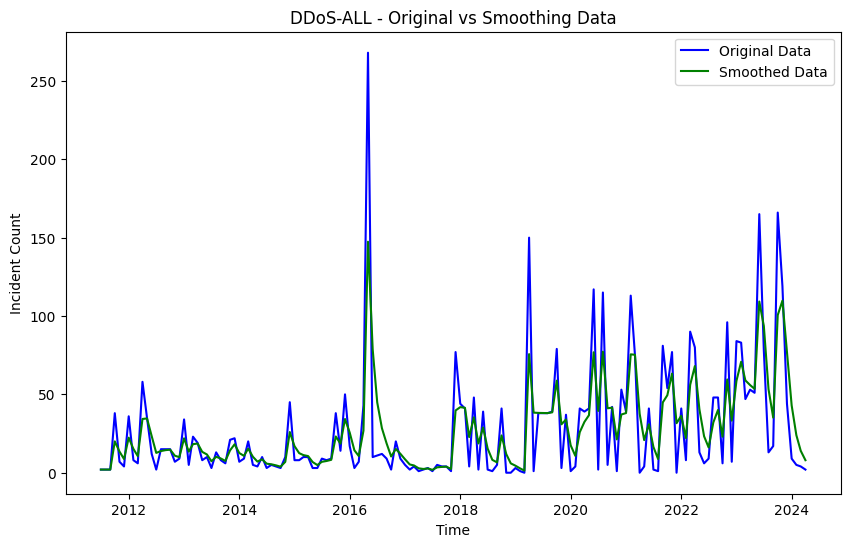

Iteration 4 out of 100


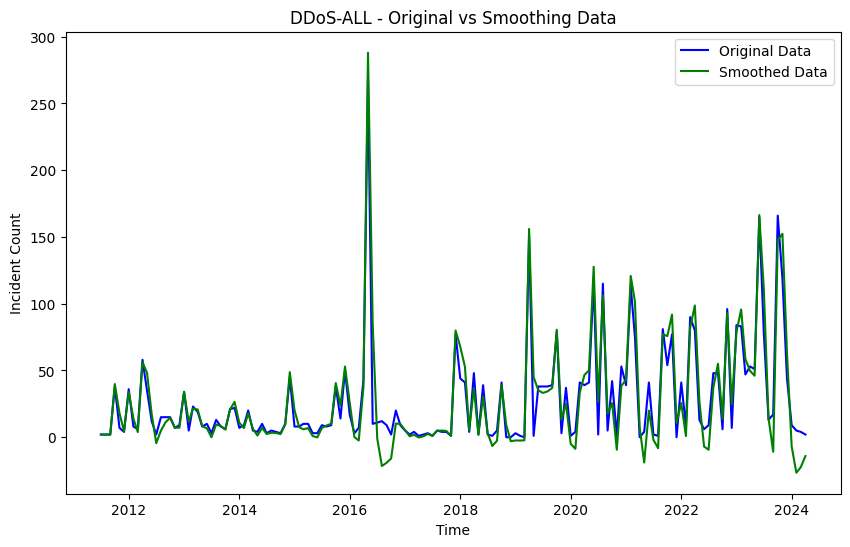

KeyboardInterrupt: 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import random
import json
import os
import matplotlib.pyplot as plt

# SMAPE calculation function
def smape(yTrue, yPred):
    """SMAPE is used to evaluate the accuracy of the predictions."""
    denominator = (np.abs(yTrue) + np.abs(yPred))
    smape_value = np.mean(2 * np.abs(yPred - yTrue) / np.where(denominator == 0, 1, denominator)) * 100
    return smape_value

# Exponential Smoothing
def exponential_smoothing(series, alpha):
    """Apply exponential smoothing to a time series. reduces noise by smoothing out fluctuations."""
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return np.array(result)

# Double Exponential Smoothing
def double_exponential_smoothing(series, alpha, beta):
    """Apply double exponential smoothing to a time series, smoothing the level, and Beta is for smoothing the trend."""
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return np.array(result)

# Prepare univariate data for LSTM input
def prepare_data(data, n_input):
    """Transform the time series data into sequences of input-output pairs for LSTM training """
    X, y = [], []
    for i in range(len(data) - n_input):
        X.append(data[i:(i + n_input)])
        y.append(data[i + n_input])
    return np.array(X), np.array(y)

# Build the LSTM Model
def build_model(n_input, layer, unit, dropout_rate):
    """Build an LSTM model with Monte Carlo Dropout for uncertainty estimation"""
    model = Sequential()
    model.add(Input(shape=(n_input, 1)))
    
    model.add(LSTM(unit[0], activation='relu', return_sequences=(layer > 1)))
    model.add(Dropout(dropout_rate))
    
    for i in range(1, layer):
        model.add(LSTM(unit[min(i, len(unit)-1)], activation='relu', return_sequences=(i < layer-1)))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Evaluate the model performance with confidence intervals
def evaluate_model(train, test, n_input, layer, unit, dropout_rate, scaler, epochs):
    train_x, train_y = prepare_data(train, n_input)
    test_x, test_y = prepare_data(test, n_input)
    
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], 1))
    
    model = build_model(n_input, layer, unit, dropout_rate)
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    model.fit(train_x, train_y, epochs=epochs, batch_size=8, validation_split=0.2, callbacks=[es], verbose=0)
    
    n_iterations = 20
    predictions_mc = np.array([model(test_x, training=True) for _ in range(n_iterations)])
    
    predictions_mean = np.mean(predictions_mc, axis=0).reshape(-1, 1)
    predictions_std = np.std(predictions_mc, axis=0).reshape(-1, 1)
    
    lower_bound = predictions_mean - 1.96 * predictions_std
    upper_bound = predictions_mean + 1.96 * predictions_std
    
    predictions_mean = scaler.inverse_transform(predictions_mean)
    lower_bound = scaler.inverse_transform(lower_bound)
    upper_bound = scaler.inverse_transform(upper_bound)
    y_test_inv = scaler.inverse_transform(test_y.reshape(-1, 1))
    
    smape_value = smape(y_test_inv, predictions_mean)
    mae = mean_absolute_error(y_test_inv, predictions_mean)
    rmse = np.sqrt(mean_squared_error(y_test_inv, predictions_mean))
    
    return smape_value, mae, rmse, predictions_mean, y_test_inv, lower_bound, upper_bound

# Main execution for univariate forecasting
if __name__ == "__main__":
    # Load and preprocess data
    data = pd.read_csv('/Users/ashit/Documents/msc-projects-2023-4-aanand1304/Dataset/FinalDataset.csv')
    data['Date'] = pd.to_datetime(data['Date'], format='%b-%y')
    data.set_index('Date', inplace=True)

    attacks = ['DDoS-ALL', 'Phishing-ALL', 'Ransomware-ALL', 'Password Attack-ALL', 'SQL Injection-ALL', 'Account Hijacking-ALL', 
            'Defacement-ALL', 'Trojan-ALL', 'Vulnerability-ALL', 'Zero-day-ALL', 'Malware-ALL', 'Advanced persistent threat-ALL', 
            'XSS-ALL', 'Data Breach-ALL', 'Disinformation/Misinformation-ALL', 'Targeted Attack-ALL','Adware-ALL',
            'Brute Force Attack-ALL', 'Malvertising-ALL', 'Backdoor-ALL', 'Botnet-ALL', 'Cryptojacking-ALL',
            'Worms-ALL', 'Spyware-ALL']

    # Create directories for saving best parameters and plots
    output_param_dir = 'univariateparam'
    output_plot_dir = 'univariateplot'
    os.makedirs(output_param_dir, exist_ok=True)
    os.makedirs(output_plot_dir, exist_ok=True)

    # Hyperparameters for random search
    alphas = [0.05, 0.2, 0.5, 0.7, 1]
    betas = [0.3, 0.5, 0.7, 1]
    lags = [1, 3, 6, 12]
    epochs_list = [100, 200, 300, 400, 500]
    dropout_rates = [0.1, 0.15, 0.2]

    # Loop through each attack type (univariate forecast for each)
    for attack in attacks:
        print(f"Processing attack: {attack}")

        # Select the data for the current attack (only one column for univariate)
        attack_data = data[attack].values.reshape(-1, 1)

        best_smape = float('inf')
        best_params = {}
        best_model = None

        iterations = 100

        # Iterate through random hyperparameters to find the best configuration
        for iteration in range(iterations):
            print(f"Iteration {iteration + 1} out of {iterations}")

            # Randomly generate hyperparameters
            alpha = random.choice(alphas)
            beta = random.choice(betas)
            n_input = random.choice(lags)
            n_epochs = random.choice(epochs_list)
            layer = random.choice([1, 2, 3])
            dropout_rate = random.choice(dropout_rates)


            # Apply smoothing
            if alpha != 1 and beta != 1:
                smoothed_data = double_exponential_smoothing(attack_data.flatten(), alpha, beta).reshape(-1, 1)
            elif alpha != 1 and beta == 1:
                smoothed_data = exponential_smoothing(attack_data.flatten(), alpha).reshape(-1, 1)
            else:
                smoothed_data = attack_data
                
           # Plot data before and after smoothing on the same graph
            plt.figure(figsize=(10, 6))
            plt.plot(data.index, attack_data.flatten(), label='Original Data', color='blue')
            plt.plot(data.index, smoothed_data.flatten(), label='Smoothed Data', color='green')
            plt.title(f'{attack} - Original vs Smoothing Data')
            plt.xlabel('Time')
            plt.ylabel('Incident Count')
            plt.legend()
            plt.show()

            # Scale the smoothed data
            scaler = RobustScaler()
            scaled_data = scaler.fit_transform(smoothed_data)

            # Split into train and test sets
            train_size = len(scaled_data) - 36
            train, test = scaled_data[:train_size], scaled_data[train_size:]
            test_dates = data.index[train_size:]

            if layer == 1:
                units = [random.choice([16, 32])]
            elif layer == 2:
                units = [random.choice([100, 200]), random.choice([50, 100])]
            else:
                units = [random.choice([200, 400]), random.choice([100, 200]), random.choice([50, 100])]

            # Evaluate the model with the current hyperparameters
            smape_value, mae, rmse, predictions_mean, y_test_inv, lower_bound, upper_bound = evaluate_model(
                train, test, n_input, layer, units, dropout_rate, scaler, n_epochs
            )

            # Save the best model parameters
            if smape_value < best_smape:
                best_smape = smape_value
                best_params = {
                    'alpha': alpha, 'beta': beta, 'n_input': n_input, 'n_epochs': n_epochs,
                    'layer': layer, 'units': units, 'dropout_rate': dropout_rate
                }
                best_predictions_mean = predictions_mean
                best_y_test_inv = y_test_inv
                best_lower_bound = lower_bound
                best_upper_bound = upper_bound

        # Save the best parameters for the current attack in a separate JSON file
        file_path = os.path.join(output_param_dir, f'{attack}_best_params.json')
        data_to_save = {
            "SMAPE": best_smape,
            "Best Parameters": best_params
        }
        with open(file_path, 'w') as f:
            json.dump(data_to_save, f)

        # Adjust test_dates to match the length of best_y_test_inv
        test_dates = test_dates[-len(best_y_test_inv):]

        print(f"Best parameters for {attack} saved to {file_path}.")
        print(f"Best SMAPE for {attack}: {best_smape}")
        print(f"Best MAE: {mae}")
        print(f"Best RMSE: {rmse}")

        # Plot the actual vs predicted values and save the plot
        plt.figure(figsize=(10, 6))

        # Plot actual values and predicted mean values
        plt.plot(test_dates, best_y_test_inv, label='Actual', color='blue', linewidth=2)
        plt.plot(test_dates, best_predictions_mean, label='Predicted Mean', color='red', linewidth=2)

        # Plot the confidence intervals (upper and lower bounds)
        plt.fill_between(
            test_dates,
            best_lower_bound.flatten(),   # Lower bound of the 95% confidence interval
            best_upper_bound.flatten(),   # Upper bound of the 95% confidence interval
            color='green', alpha=0.3, label='95% Confidence Interval'
        )

        # Add titles, labels, and legend
        plt.title(f'{attack} (SMAPE: {best_smape:.2f}, Univariate)')
        plt.xlabel('Time')
        plt.ylabel('Incident Count')
        plt.legend()

        # Save the plot
        plot_path = os.path.join(output_plot_dir, f'{attack}_actual_vs_predicted.png')
        plt.savefig(plot_path)
        plt.show()
        plt.close()

        print(f"Plot for {attack} saved to {plot_path}.")

print("Best parameters for all attacks have been saved individually.")
